In [50]:
import os
import json
import csv
import tld
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd

client = Client(n_workers=2, threads_per_worker=2, memory_limit='6GB')

In [3]:
DATASET_PATH = "datasets"

filename = "quotes-2020.parquet"

dataset = dd.read_parquet(os.path.join(DATASET_PATH, filename))

In [4]:
# Convert date column to datetime objects
dataset["date"] = dd.to_datetime(dataset["date"])

In [22]:
ds_by_day = dataset.set_index("date").resample("1D")
number_of_quotes_per_day = ds_by_day.size().compute()

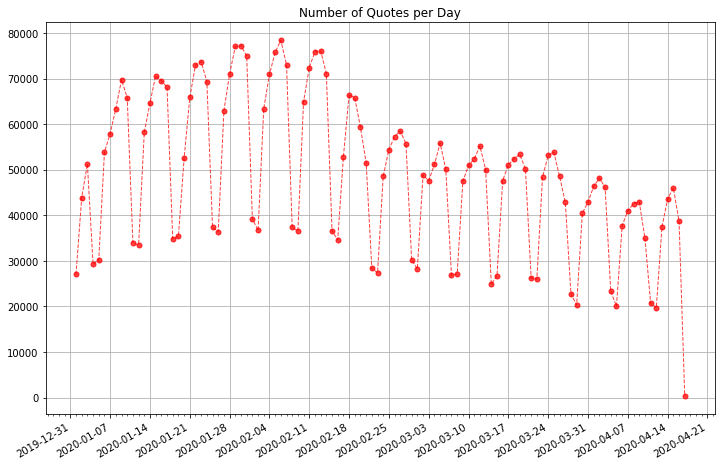

In [78]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.set_title("Number of Quotes per Day")

# Major ticks every week.
fmt_week = mdates.WeekdayLocator(interval=1)
ax.xaxis.set_major_locator(fmt_week)

# Minor ticks every day.
fmt_day = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_day)

# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Round to nearest months.
datemin = np.datetime64(number_of_quotes_per_day.index[0], 'W')
datemax = np.datetime64(number_of_quotes_per_day.index[-1], 'W') + np.timedelta64(1, 'W')
ax.set_xlim(datemin, datemax)
ax.grid(True)
ax.plot(number_of_quotes_per_day, c="r", linewidth=1, alpha=0.75, marker="o", linestyle="--", markersize=5)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

I wonder why there is a sharp decrease in the middle of each week. Is it because of the weekdays/weekends?

In [91]:
dataset["day_of_week"] = dataset["date"].dt.day_name()
ds_by_weekdays = dataset.groupby(dataset["day_of_week"])
number_of_quotes_per_weekday = ds_by_weekdays.size().compute()

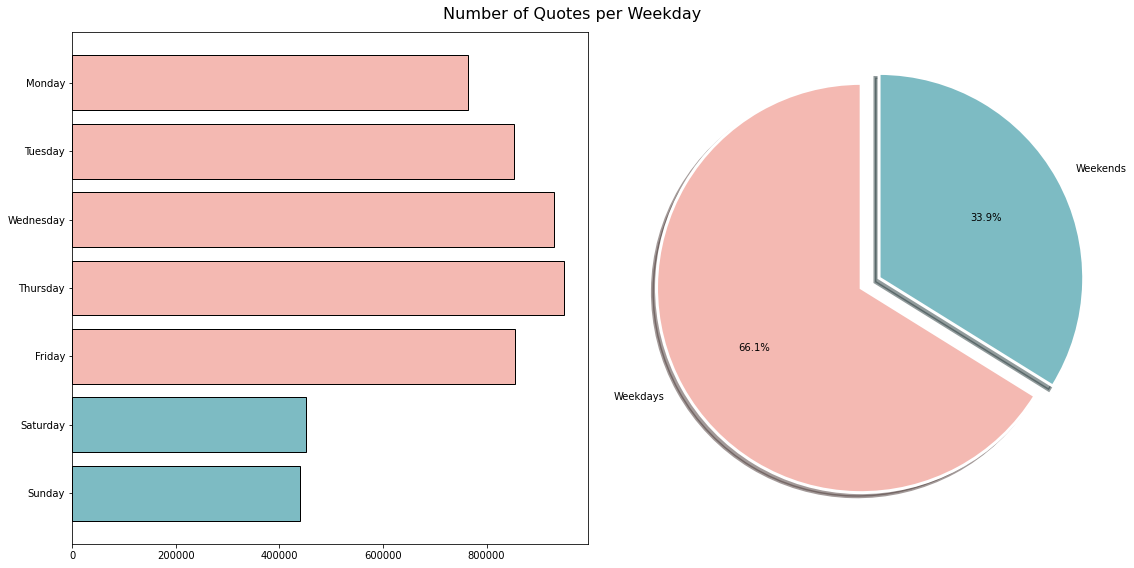

In [131]:
# Sort the index by the day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_type = (days_of_week[:5], days_of_week[5:])

mapping = {day: i for i, day in enumerate(reversed(days_of_week))}
key = number_of_quotes_per_weekday.index.map(mapping)
number_of_quotes_per_weekday = number_of_quotes_per_weekday.iloc[key.argsort()]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Number of Quotes per Weekday", fontsize=16)

colors = ["#7DBBC3", "#7DBBC3", "#F4B9B2", "#F4B9B2", "#F4B9B2", "#F4B9B2", "#F4B9B2"]
ax[0].barh(number_of_quotes_per_weekday.index, number_of_quotes_per_weekday, edgecolor="black", color=colors)

ax[1].pie([number_of_quotes_per_weekday.loc[x].mean() for x in day_type], labels=["Weekdays", "Weekends"], autopct='%.1f%%', shadow=True, startangle=90, colors=["#F4B9B2", "#7DBBC3"], wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, explode=(0, 0.1))
plt.tight_layout()

Aha, we were right! Apparently many people decide to stay silent during the weekend.